In [2]:
# 线性回归模型

%matplotlib notebook
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

import matplotlib.pyplot as plt

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] # y
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # x
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

t_c,t_u

(tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000,
         -4.0000,  6.0000, 13.0000, 21.0000]),
 tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
         21.8000, 48.4000, 60.4000, 68.4000]))

<IPython.core.display.Javascript object>


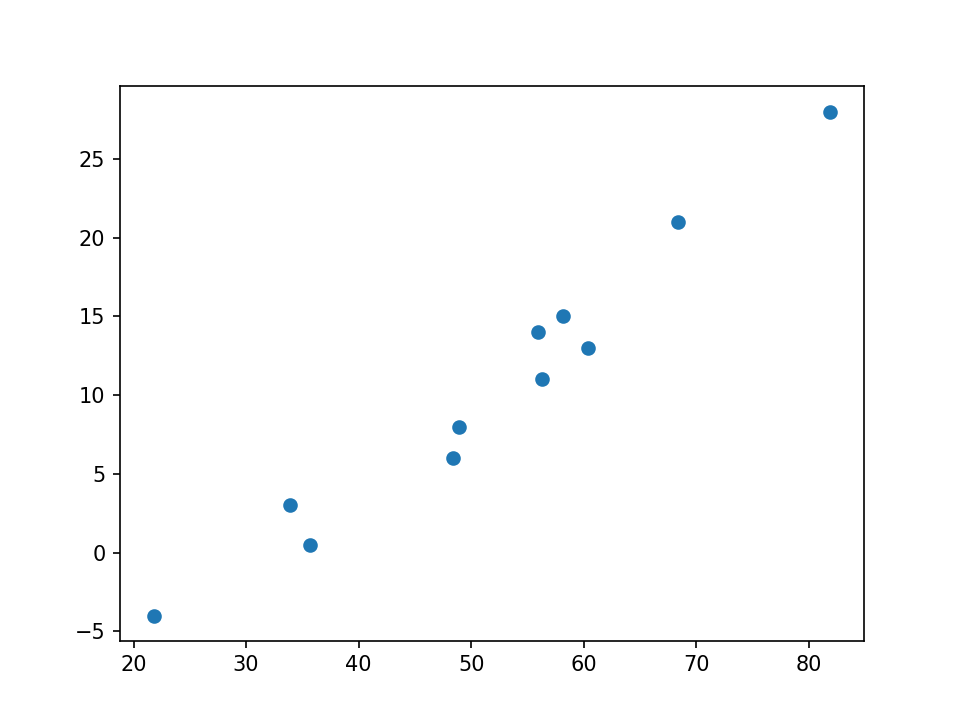

In [8]:
plt.plot(t_u.numpy(),t_c.numpy(),'o')

In [5]:
def model(input_tensor,w,b):
    return input_tensor * w + b

In [10]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [12]:
l = torch.tensor([1,3,5,7])
l**2

tensor([ 1,  9, 25, 49])

In [6]:
w = torch.ones((11,)) # 可以用（）替换（11，），广播机制
b = torch.zeros((11,))
print(w,b)

w = torch.ones(()) 
b = torch.zeros(())
print(w,b)

t_p = model(t_u, w, b)
print(t_p.size())
t_p

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(1.) tensor(0.)
torch.Size([11])


tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [17]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [21]:
# 计算梯度

delta = 0.1 # 扰动

# 这里是直接利用导数的定义求近似梯度，Δ
loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta) # delta - （-delta）
loss_rate_of_change_w

tensor(4517.2974)

In [22]:
# 步长（学习率）
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w
w

tensor(-44.1730)

In [23]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b
b

tensor(46.)

In [24]:
# 计算损失函数的梯度
def dloss_fn(t_p, t_c):
    # 除以向量的长度是为了对梯度进行归一化，以确保梯度的大小不会受到输入向量的长度的影响
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1> 直接用了x平方的导数表达式的计算
    return dsq_diffs

In [25]:
# 模型在w方向的梯度，即以w为自变量求梯度
def dmodel_dw(t_u, w, b):
    return t_u

# 模型对b求梯度
def dmodel_db(t_u, w, b):
    return 1.0

In [27]:
# 利用链式法则得出最后模型整体的梯度下降
'''
首先，我们计算损失函数关于预测值y的导数：dL/dy。
然后，我们计算预测值y关于权重w和偏差b的导数：dy/dw和dy/db。
最后，应用链式法则，将上述导数相乘，得到损失函数关于权重w和偏差b的梯度：dL/dw和dL/db。

具体而言，梯度计算如下：
对于权重w的梯度：dL/dw = dL/dy * dy/dw = (dL/dy) * x
对于偏差b的梯度：dL/db = dL/dy * dy/db = (dL/dy) * 1
'''
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1> 合成一个矩阵，是为了下文训练函数传入参数方便计算

print(w,b)
s = torch.stack([w, b])
print(s, s.shape)

tensor(-44.1730) tensor(46.)
tensor([-44.1730,  46.0000]) torch.Size([2])


In [28]:
# 训练函数
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad # 这种方式不要在pytorch里用，因为torch的张量有其他属性，这种赋值不会继承

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

In [29]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2,  # 学习率太大导致梯度爆炸
    params = torch.tensor([1.0, 0.0]), # 对应grad_fn的return stack函数
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
Epoch 2, Loss 5802484.500000
Epoch 3, Loss 19408029696.000000
Epoch 4, Loss 64915905708032.000000
Epoch 5, Loss 217130525461053440.000000
Epoch 6, Loss 726257583152928129024.000000
Epoch 7, Loss 2429183416467662896627712.000000
Epoch 8, Loss 8125122549611731432050262016.000000
Epoch 9, Loss 27176882120842590626938030653440.000000
Epoch 10, Loss 90901105189019073810297959556841472.000000
Epoch 11, Loss inf
Epoch 12, Loss inf
Epoch 13, Loss inf
Epoch 14, Loss inf
Epoch 15, Loss inf
Epoch 16, Loss inf
Epoch 17, Loss inf
Epoch 18, Loss inf
Epoch 19, Loss inf
Epoch 20, Loss inf
Epoch 21, Loss inf
Epoch 22, Loss inf
Epoch 23, Loss nan
Epoch 24, Loss nan
Epoch 25, Loss nan
Epoch 26, Loss nan
Epoch 27, Loss nan
Epoch 28, Loss nan
Epoch 29, Loss nan
Epoch 30, Loss nan
Epoch 31, Loss nan
Epoch 32, Loss nan
Epoch 33, Loss nan
Epoch 34, Loss nan
Epoch 35, Loss nan
Epoch 36, Loss nan
Epoch 37, Loss nan
Epoch 38, Loss nan
Epoch 39, Loss nan
Epoch 40, Loss nan
Epoch 41, Loss

tensor([nan, nan])

In [30]:
# 更细致的训练函数，设置打印参数和跳出
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [31]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4,  # 降低学习率即可收敛
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

In [35]:
# 缩小原始参数，其实就是变相归一化/标准化
t_un = 0.1 * t_u

# 也可以收敛
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-3, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>在这替换
    t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.0776, 0.0106])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 74.413010
    Params: tensor([1.1506, 0.0205])
    Grad:   tensor([-72.9389,  -9.8146])
Epoch 3, Loss 69.160568
    Params: tensor([1.2191, 0.0295])
    Grad:   tensor([-68.5472,  -9.0394])
...
Epoch 10, Loss 46.143223
    Params: tensor([1.5964, 0.0747])
    Grad:   tensor([-44.4238,  -4.7815])
Epoch 11, Loss 44.207150
    Params: tensor([1.6382, 0.0790])
    Grad:   tensor([-41.7614,  -4.3117])
...
Epoch 99, Loss 28.960478
    Params: tensor([ 2.3202, -0.0683])
    Grad:   tensor([-0.6849,  2.8990])
Epoch 100, Loss 28.951599
    Params: tensor([ 2.3208, -0.0712])
    Grad:   tensor([-0.6747,  2.9003])
...
Epoch 4000, Loss 9.843812
    Params: tensor([ 3.7982, -8.4202])
    Grad:   tensor([-0.2667,  1.5095])
Epoch 5000, Loss 7.851448
    Params: tensor([ 4.0435, -9.8084])
    Grad:   tensor([-0.2250,  1.2737])


<IPython.core.display.Javascript object>


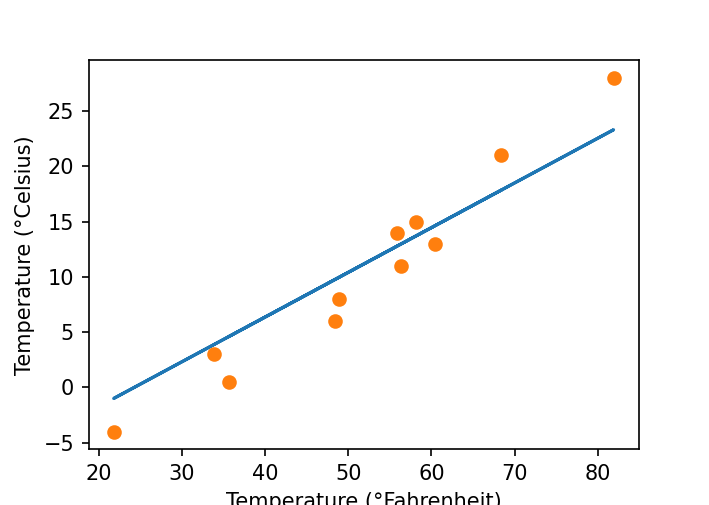

In [37]:
%matplotlib notebook

t_p = model(t_un, *params)  # <1>

# fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>detach()返回新张量，得到的张量不会具有梯度
plt.plot(t_u.numpy(), t_c.numpy(), 'o')